In [19]:
# Add these imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
import warnings
warnings.filterwarnings('ignore')

In [31]:
# Load and explore data
df = pd.read_csv('https://raw.githubusercontent.com/SumanGouda/Scikit-Learn-/refs/heads/main/PROJECT/HEART%20DISEASE/heart_disease_uci.csv')

# Basic exploration
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
print("\nTarget variable 'num' distribution:\n", df['num'].value_counts())

Dataset shape: (920, 16)

Missing values:
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Data types:
 id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object

Target variable 'num' distribution:
 num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


In [32]:
df.columns 

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

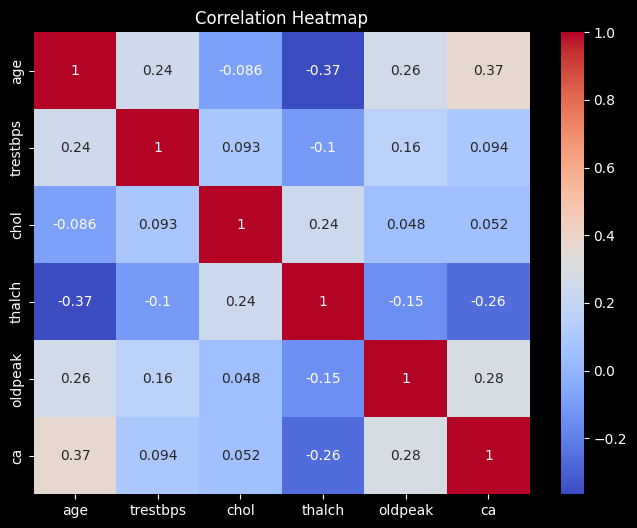

In [27]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'dataset']

# Draw a corellation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### <span style="color:cyan"><i>Data Cleaning</i></span>

In [24]:
df[df['chol'] > 450]

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
152,153,67,Female,Cleveland,non-anginal,115.0,564.0,False,lv hypertrophy,160.0,False,1.6,flat,0.0,reversable defect,0
434,435,53,Female,Hungary,atypical angina,113.0,468.0,NaN,normal,127.0,False,0.0,NaN,NaN,NaN,0
500,501,40,Male,Hungary,asymptomatic,120.0,466.0,NaN,normal,152.0,True,1.0,flat,NaN,fixed defect,1
528,529,32,Male,Hungary,asymptomatic,118.0,529.0,False,normal,130.0,False,0.0,NaN,NaN,NaN,1
546,547,54,Male,Hungary,asymptomatic,130.0,603.0,True,normal,125.0,True,1.0,flat,NaN,NaN,1
568,569,53,Male,Hungary,non-anginal,145.0,518.0,False,normal,130.0,False,0.0,NaN,NaN,NaN,1
584,585,44,Male,Hungary,asymptomatic,135.0,491.0,False,normal,135.0,False,0.0,NaN,NaN,NaN,1
800,801,58,Male,VA Long Beach,asymptomatic,132.0,458.0,True,normal,69.0,False,1.0,downsloping,NaN,NaN,0


In [33]:
# Define columns more precisely
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'dataset']
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Handle missing values more strategically

# Convert appropriate columns to proper data types
df['sex'] = df['sex'].astype('category')
df['cp'] = df['cp'].astype('category')
df['fbs'] = df['fbs'].astype('category')
df['restecg'] = df['restecg'].astype('category')
df['exang'] = df['exang'].astype('category')
df['slope'] = df['slope'].astype('category')
df['thal'] = df['thal'].astype('category')

# Handle outliers in numerical columns
import plotly.express as px
from plotly.subplots import make_subplots

def handle_outliers(df, columns):
    fig = make_subplots(rows=1, cols=len(columns), subplot_titles=[f"Box Plot of {col} (Before Outlier Removal)" for col in columns])
    for i, col in enumerate(columns):
        fig.add_trace(px.box(df, y=col).data[0], row=1, col=i+1)
        fig.update_xaxes(title_text=col, row=1, col=i+1)
    fig.update_layout(template='plotly_dark', width=500*len(columns), height=500)
    fig.show()
    return df

df = handle_outliers(df, numerical_cols)

### Handling the cholesterol column 
1. As the chol value can not be zero so we would remove it & in the extreme case like above 600 which is not possible

In [ ]:
df.drop(df[(df['chol'] == 0) & (df['chol'] > 600)].index, inplace=True)


### Handling the trestbps column
1. As the trestbps value of a person can not be zero so removing that perticular row

In [35]:
df.drop(df[df['trestbps'] == 0].index, inplace=True)
df[df['trestbps'] == 200]

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
126,127,56,Female,Cleveland,asymptomatic,200.0,288.0,True,lv hypertrophy,133.0,True,4.0,downsloping,2.0,reversable defect,3
548,549,54,Male,Hungary,asymptomatic,200.0,198.0,False,normal,142.0,True,2.0,flat,NaN,NaN,1
680,681,61,Male,Switzerland,non-anginal,200.0,0.0,NaN,st-t abnormality,70.0,False,0.0,NaN,NaN,normal,3
701,702,64,Female,Switzerland,asymptomatic,200.0,0.0,False,normal,140.0,True,1.0,flat,NaN,normal,3


In [4]:
df['trestbps'] = df.replace(0, np.nan)['trestbps']
df['chol'] = df.replace(0, np.nan)['chol']

# Create new features
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 50, 60, 70, 100], labels=['20-40', '40-50', '50-60', '60-70', '70+'])
df['bp_category'] = pd.cut(df['trestbps'], bins=[0, 120, 140, 200], labels=['Normal', 'Elevated', 'High'])
df['chol_risk'] = pd.cut(df['chol'], bins=[0, 200, 240, 300], labels=['Normal', 'Borderline', 'High'])
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,age_group,bp_category,chol_risk
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,60-70,High,Borderline
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,60-70,High,High
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,60-70,Normal,Borderline
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,20-40,Elevated,High
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,40-50,Elevated,Borderline


In [5]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'dataset']
categorical_cols_most_missing = ['fbs', 'thal', 'slope', 'exang']
categorical_cols_mcar = ['restecg']

numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca' ]
missing_numerical_cols_mcar = ['trestbps', 'chol']
missing_numerical_cols_not_mcar = ['thalch', 'oldpeak']
not_zero_cols = ['chol', 'trestbps']


#### Handling those columns whose values can not be zero or negerive.

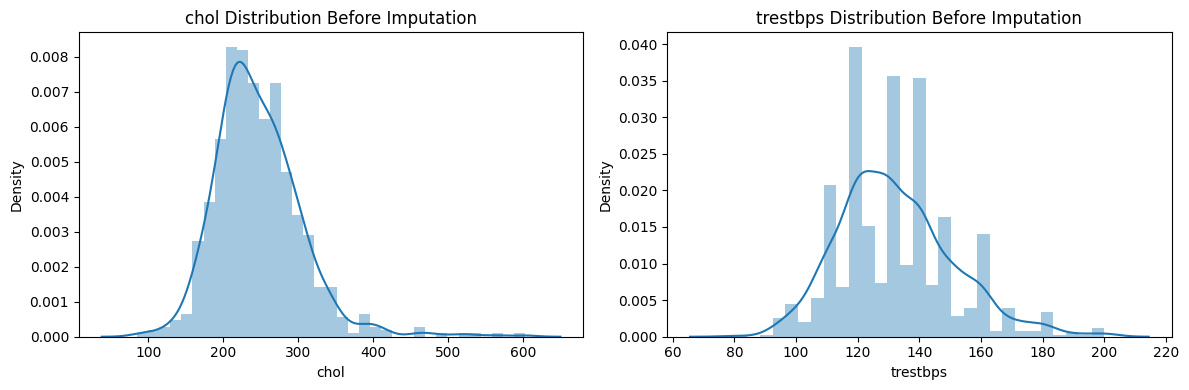

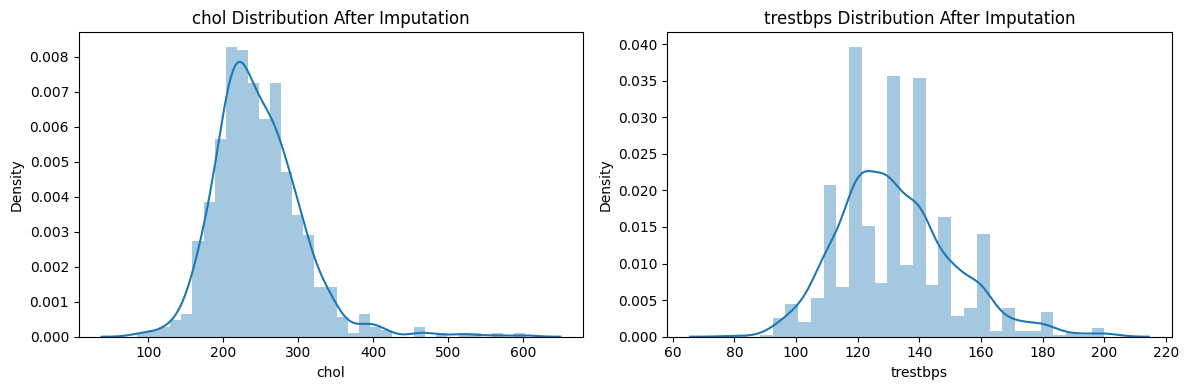

In [6]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(1, len(not_zero_cols), figsize=(12, 4))

# Loop through each column and create a distplot
for i, col in enumerate(not_zero_cols):
    sns.distplot(df[col], ax=axs[i])

# Set the title and labels for each subplot
for i, col in enumerate(not_zero_cols):
    axs[i].set_title(f'{col} Distribution Before Imputation')

# Layout so plots do not overlap
fig.tight_layout()

# Making all the zero values to NaN then plotting the distributions curve
fig, axs = plt.subplots(1, len(not_zero_cols), figsize=(12, 4))

# Loop through each column and create a distplot
for i, col in enumerate(not_zero_cols):
    df[col] = df[col].replace(0, np.nan)
    sns.distplot(df[col], ax=axs[i])

# Set the title and labels for each subplot
for i, col in enumerate(not_zero_cols):
    axs[i].set_title(f'{col} Distribution After Imputation')

# Layout so plots do not overlap
fig.tight_layout()

# Show the plot
plt.show()


#### Handling columns in <i>missing_numerical_mcar</i>

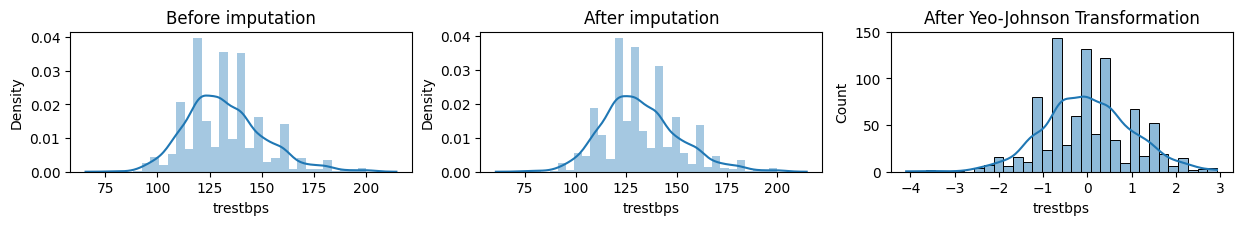

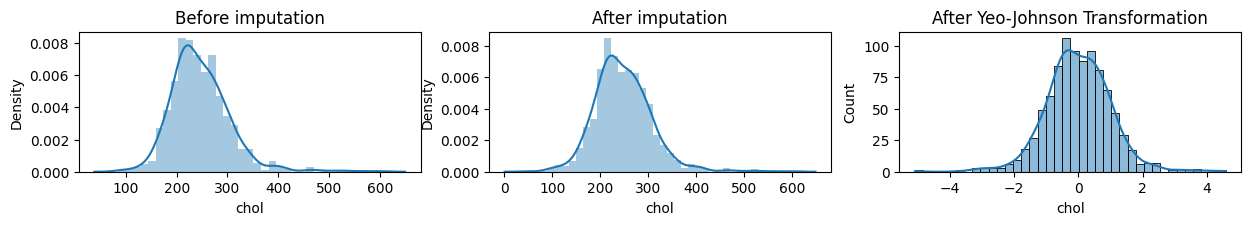

In [7]:
# Befroe imputation
plt.figure(figsize=(15, 4))
plt.subplot(2, 3, 1)
sns.distplot(df['trestbps'])    
plt.title('Before imputation')

# Impute missing cholesterol values by generating random samples from a normal distribution
# that matches the observed data's mean and slightly increased standard deviation (1.1x),
# while preserving the original DataFrame's index structure to ensure correct alignment.
mean_val, std_val = df['trestbps'].mean(), df['trestbps'].std()
imputed_vals = pd.Series(
    np.random.normal(mean_val, std_val * 1.1, size=df['trestbps'].isna().sum()),
    index=df[df['trestbps'].isna()].index  # Preserve original indices
)
df['trestbps'] = df['trestbps'].fillna(imputed_vals)    # Random imputation from mean and std

# After imputation
plt.subplot(2, 3, 2)
sns.distplot(df['trestbps'])
plt.title('After imputation')

# Apply Yeo-Johnson transformation
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
df['trestbps'] = pt.fit_transform(df[['trestbps']])

# Plot the transformed data
plt.subplot(2, 3, 3)
sns.histplot(df['trestbps'], kde=True)  # Replaces distplot
plt.title('After Yeo-Johnson Transformation')
plt.show()

# Same for the chol column

# Befroe imputation
plt.figure(figsize=(15, 4))
plt.subplot(2, 3, 1)
sns.distplot(df['chol'])    
plt.title('Before imputation')

# Impute missing cholesterol values by generating random samples from a normal distribution
# that matches the observed data's mean and slightly increased standard deviation (1.1x),
# while preserving the original DataFrame's index structure to ensure correct alignment.
mean_val, std_val = df['chol'].mean(), df['chol'].std()
imputed_vals = pd.Series(
    np.random.normal(mean_val, std_val * 1.1, size=df['chol'].isna().sum()),
    index=df[df['chol'].isna()].index  # Preserve original indices
)
df['chol'] = df['chol'].fillna(imputed_vals)# Random imputation from mean and std

# After imputation
plt.subplot(2, 3, 2)
sns.distplot(df['chol'])
plt.title('After imputation')

# Apply Yeo-Johnson transformation
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
df['chol'] = pt.fit_transform(df[['chol']])

# Plot the transformed data
plt.subplot(2, 3, 3)
sns.histplot(df['chol'], kde=True)  # Replaces distplot
plt.title('After Yeo-Johnson Transformation')
plt.show()


##### Scaling the numerical colulmns

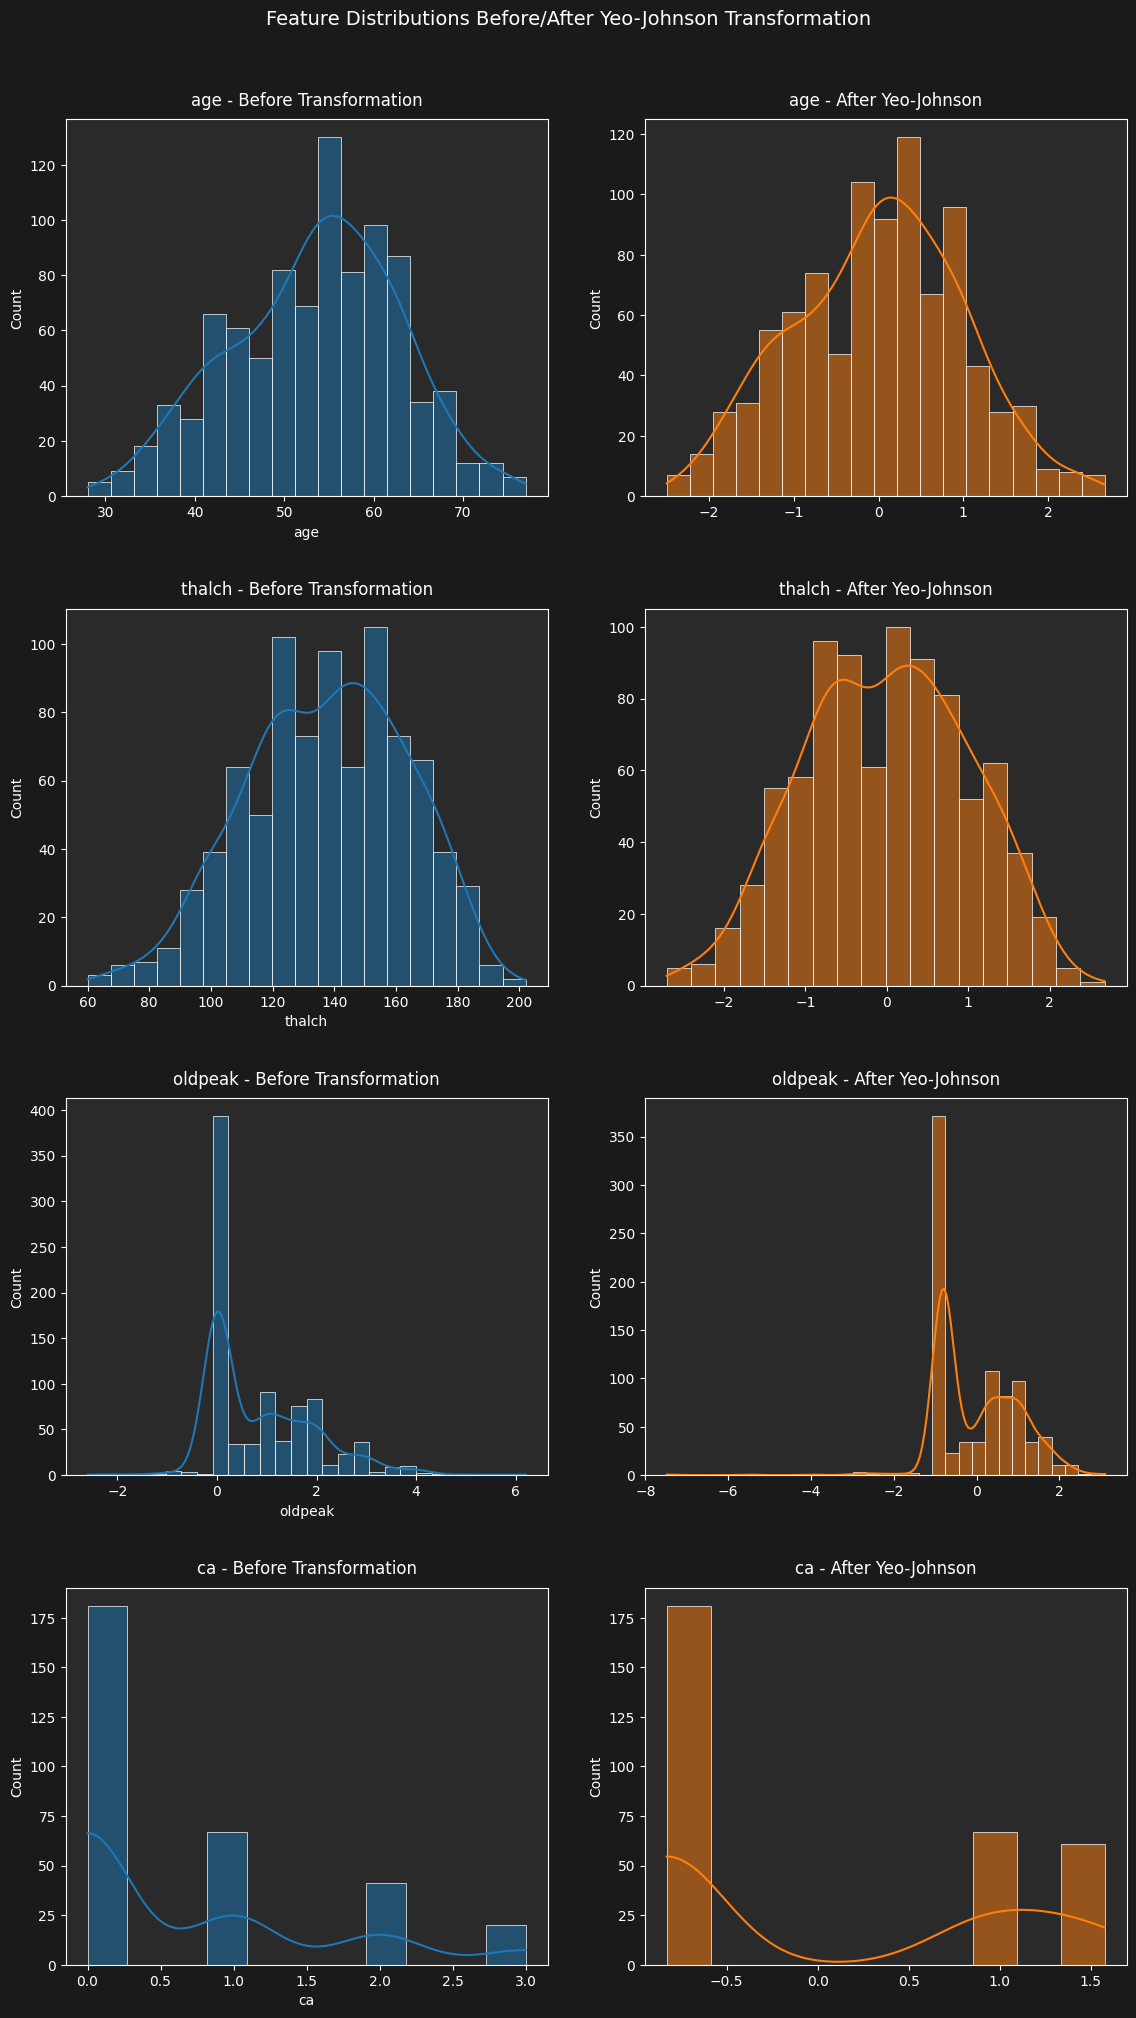

In [8]:
# Set dark theme
plt.style.use('dark_background')

# Create subplots
req_cols = [col for col in numerical_cols if col not in missing_numerical_cols_mcar]
n = len(req_cols)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 5 * n), facecolor='#1a1a1a')

pt = PowerTransformer(method='yeo-johnson')

for i, col in enumerate(req_cols):
    # Before transformation
    sns.histplot(df[col], ax=axes[i, 0], kde=True, color='#1f77b4', edgecolor='w', linewidth=0.5)
    axes[i, 0].set_title(f'{col} - Before Transformation', color='white', pad=10)
    axes[i, 0].set_facecolor('#2a2a2a')
    
    # After transformation
    transformed = pt.fit_transform(df[[col]])
    sns.histplot(transformed.flatten(), ax=axes[i, 1], kde=True, color='#ff7f0e', edgecolor='w', linewidth=0.5)
    axes[i, 1].set_title(f'{col} - After Yeo-Johnson', color='white', pad=10)
    axes[i, 1].set_facecolor('#2a2a2a')

# Adjust layout
plt.tight_layout(pad=3.0)
plt.suptitle('Feature Distributions Before/After Yeo-Johnson Transformation', 
             y=1.02, color='white', fontsize=14)
plt.show()

##### For Oldpeak Column

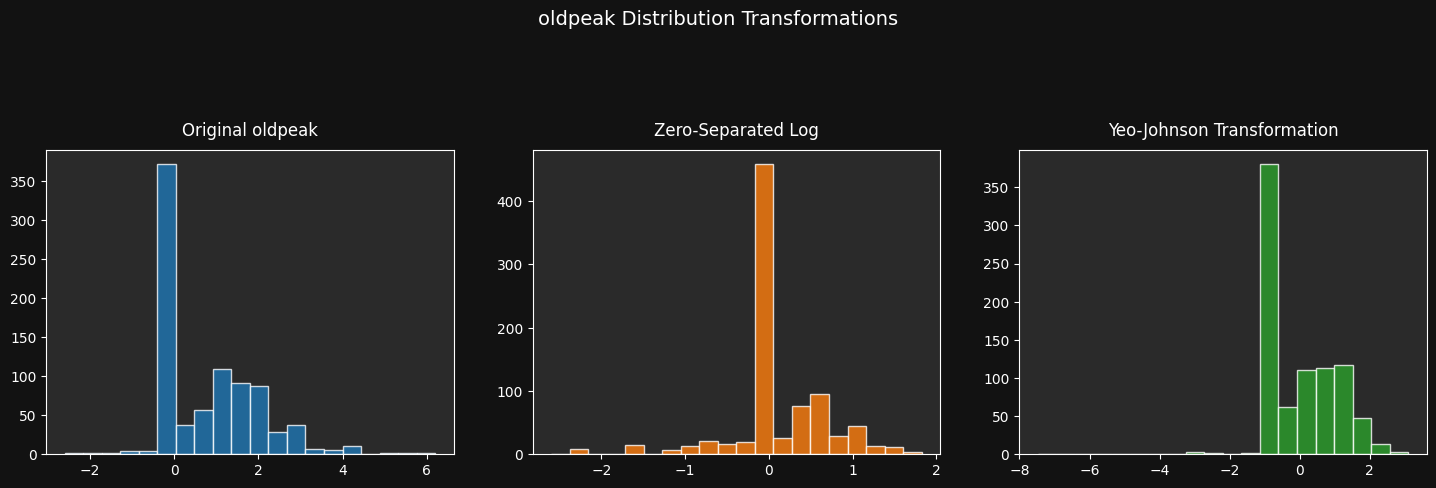

In [9]:
# Set dark theme
plt.style.use('dark_background')

# Create a copy for transformation
df['oldpeak_log'] = df['oldpeak'].copy()
mask = df['oldpeak'] > 0  # only positive values
df.loc[mask, 'oldpeak_log'] = np.log(df.loc[mask, 'oldpeak'])

# Compare histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5), facecolor='#121212')

# Custom colors for dark theme
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Original distribution
axes[0].hist(df['oldpeak'], bins=20, color=colors[0], edgecolor='white', alpha=0.8)
axes[0].set_title('Original oldpeak', color='white', pad=10)
axes[0].set_facecolor('#2a2a2a')

# Log-transformed (zero-separated)
axes[1].hist(df['oldpeak_log'], bins=20, color=colors[1], edgecolor='white', alpha=0.8)
axes[1].set_title('Zero-Separated Log', color='white', pad=10)
axes[1].set_facecolor('#2a2a2a')

# Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
df['oldpeak_yeojohnson'] = pt.fit_transform(df[['oldpeak']])
axes[2].hist(df['oldpeak_yeojohnson'], bins=20, color=colors[2], edgecolor='white', alpha=0.8)
axes[2].set_title('Yeo-Johnson Transformation', color='white', pad=10)
axes[2].set_facecolor('#2a2a2a')

# Add super title
plt.suptitle('oldpeak Distribution Transformations', y=1.02, color='white', fontsize=14)

# Adjust layout
plt.tight_layout(pad=3.0)
plt.show()

##### For ca column

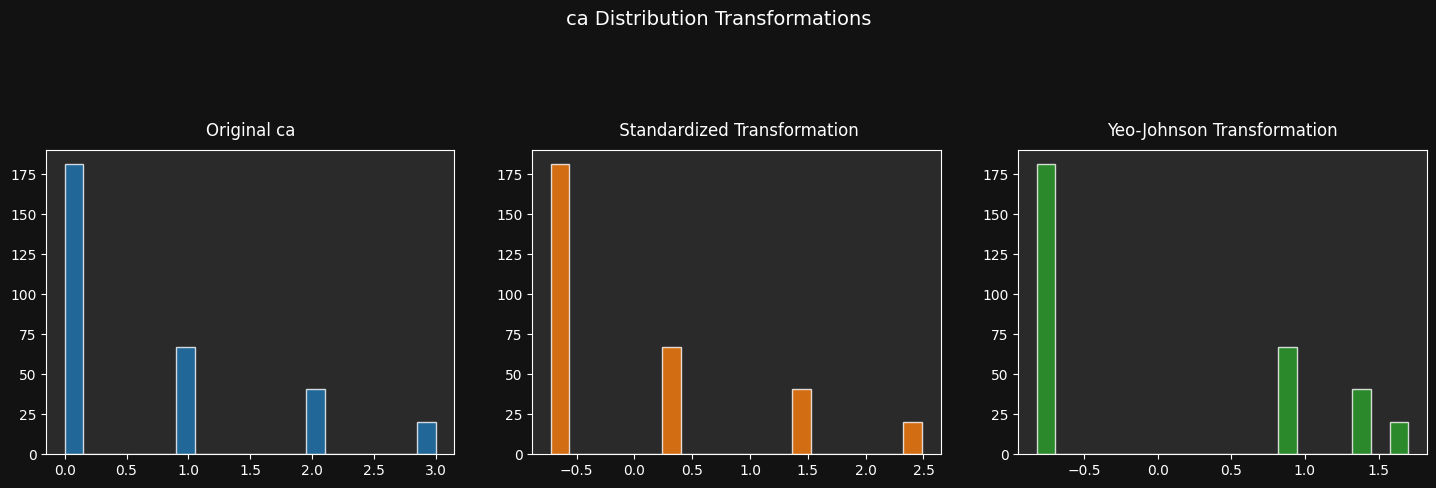

In [11]:
# Apply log transformer to the ca column 

# Set dark theme
plt.style.use('dark_background')

# Compare histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5), facecolor='#121212')

# Custom colors for dark theme
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Original distribution
axes[0].hist(df['ca'], bins=20, color=colors[0], edgecolor='white', alpha=0.8)
axes[0].set_title('Original ca', color='white', pad=10)
axes[0].set_facecolor('#2a2a2a')

# Apply Standardization 
scaler = StandardScaler()
df['ca_standardized'] = scaler.fit_transform(df[['ca']])
axes[1].hist(df['ca_standardized'], bins=20, color=colors[1], edgecolor='white', alpha=0.8)
axes[1].set_title(' Standardized Transformation', color='white', pad=10)
axes[1].set_facecolor('#2a2a2a')

# Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
df['ca_yeojohnson'] = pt.fit_transform(df[['ca_standardized']])
axes[2].hist(df['ca_yeojohnson'], bins=20, color=colors[2], edgecolor='white', alpha=0.8)
axes[2].set_title('Yeo-Johnson Transformation', color='white', pad=10)
axes[2].set_facecolor('#2a2a2a')

# Add super title
plt.suptitle('ca Distribution Transformations', y=1.02, color='white', fontsize=14)

# Adjust layout
plt.tight_layout(pad=3.0)
plt.show()

#### Analysing with the columns in <i>'categorical_cols_mcar'</i>

In [10]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create a new column for the NaN values
for col in categorical_cols_mcar:
    df[f'{col}_nan'] = df[col].isnull().astype(int)

# Create a figure with two subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=['Before Imputation', 'After Imputation'])

# Loop through each column and create a count plot
for col in categorical_cols_mcar:
    # Before imputation
    counts_before = df[col].value_counts()
    fig.add_trace(go.Bar(x=counts_before.index, y=counts_before.values), row=1, col=1)
    
    # Impute missing values with the most frequent value
    most_frequent_value = df[col].mode()[0]
    df[col] = df[col].fillna(most_frequent_value)
    
    # After imputation
    counts_after = df[col].value_counts()
    fig.add_trace(go.Bar(x=counts_after.index, y=counts_after.values), row=1, col=2)

# Update the layout
fig.update_layout(height=400, width=1500, template='plotly_dark', showlegend=False)

# Show the plot
fig.show()

#### Analysing with the columns in 'categorical_cosl_most_missing'

In [11]:
from sklearn.preprocessing import OrdinalEncoder

# Binary encoding for fbs and exang (keep NaNs)
df['fbs'] = df['fbs'].map({True: 1, False: 0})
df['exang'] = df['exang'].map({True: 1, False: 0})

# Ordinal encoding for slope (keep NaNs)
slope_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
)
df[['slope']] = slope_encoder.fit_transform(df[['slope']])

# One-hot encoding for thal (drop NaNs temporarily so they stay NaN later)
thal_dummies = pd.get_dummies(df['thal'], prefix='thal', dummy_na=True)
df = pd.concat([df.drop(columns=['thal']), thal_dummies], axis=1)

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.utils.validation import check_is_fitted

class LogTransformer(OneToOneFeatureMixin, TransformerMixin, BaseEstimator):
    def __init__(self):
        self._estimator_type = "transformer"
    
    def fit(self, X, y=None):
        """No fitting required"""
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = np.array(X.columns)
        return self
    
    def transform(self, X):
        """Apply log(1 + x) transformation"""
        if isinstance(X, pd.DataFrame):
            return np.log1p(X)
        return np.log1p(X)
    
    def get_feature_names_out(self, input_features=None):
        """Get output feature names"""
        if hasattr(self, 'feature_names_in_'):
            return self.feature_names_in_
        return input_features

class ZeroToNanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        """Learn and store the feature names"""
        if isinstance(X, pd.DataFrame):
            if self.columns is None:
                self.columns = X.select_dtypes(include=np.number).columns.tolist()
            self.feature_names_in_ = np.array(X.columns)
            self.n_features_in_ = len(self.feature_names_in_)
        return self
    
    def transform(self, X):
        """Replace zeros with NaN in specified columns"""
        check_is_fitted(self)
        X = X.copy()
        if isinstance(X, pd.DataFrame):
            X[self.columns] = X[self.columns].replace(0, np.nan)
            return X
        raise TypeError("Input must be a pandas DataFrame")
    
    def get_feature_names_out(self, input_features=None):
        """Get output feature names"""
        check_is_fitted(self)
        if hasattr(self, 'feature_names_in_'):
            return self.feature_names_in_
        return input_features

class RandomCategoryImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, random_state=42):
        self.columns = columns
        self.random_state = random_state
    
    def fit(self, X, y=None):
        """Learn and store the feature names"""
        if isinstance(X, pd.DataFrame):
            if self.columns is None:
                self.columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
            self.categories_ = {col: X[col].dropna().unique() for col in self.columns}
            self.feature_names_in_ = np.array(X.columns)
            self.n_features_in_ = len(self.feature_names_in_)
        return self
    
    def transform(self, X):
        """Impute missing values with random categories"""
        check_is_fitted(self)
        X = X.copy()
        if isinstance(X, pd.DataFrame):
            np.random.seed(self.random_state)
            for col in self.columns:
                mask = X[col].isna()
                if mask.any() and len(self.categories_[col]) > 0:
                    X.loc[mask, col] = np.random.choice(
                        self.categories_[col],
                        size=mask.sum()
                    )
            return X
        raise TypeError("Input must be a pandas DataFrame")
    
    def get_feature_names_out(self, input_features=None):
        """Get output feature names"""
        check_is_fitted(self)
        if hasattr(self, 'feature_names_in_'):
            return self.feature_names_in_
        return input_features

class ZeroSeparatedLogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        """Learn and store the feature names"""
        if isinstance(X, pd.DataFrame):
            if self.columns is None:
                self.columns = X.select_dtypes(include=np.number).columns.tolist()
            self.feature_names_in_ = np.array(X.columns)
            self.n_features_in_ = len(self.feature_names_in_)
        return self
    
    def transform(self, X):
        """Apply log transformation to positive values only"""
        check_is_fitted(self)
        X_log = X.copy()
        if isinstance(X_log, pd.DataFrame):
            for col in self.columns:
                mask = X_log[col] > 0
                X_log.loc[mask, col] = np.log(X_log.loc[mask, col])
            return X_log
        raise TypeError("Input must be a pandas DataFrame")
    
    def get_feature_names_out(self, input_features=None):
        """Get output feature names"""
        check_is_fitted(self)
        if hasattr(self, 'feature_names_in_'):
            return self.feature_names_in_
        return input_features

class NanOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, drop='first'):
        self.drop = drop
        self.encoder = OneHotEncoder(drop=self.drop, handle_unknown='ignore', sparse_output=False)
    
    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self
    
    def transform(self, X):
        # Get one-hot encoded output
        encoded = self.encoder.transform(X)
        
        # Replace all-zero rows (unseen/missing) with np.nan
        encoded[(encoded == 0).all(axis=1)] = np.nan
        return encoded
"""
How NanOneHotEncoder Works:
1. First applies standard OneHotEncoder with:
   - drop='first' (drops first category to avoid multicollinearity)
   - handle_unknown='ignore' (returns all zeros for unseen categories)
   - sparse_output=False (returns dense array)

2. Then post-processes the output to:
   - Convert all-zero rows (from ignored unseen categories) → np.nan
   - Keep existing np.nan values as np.nan
   - Normal one-hot encoded categories remain as 0/1 values

3. Why this matters:
   - Preserves missingness information for downstream KNNImputer
   - Handles both missing values (np.nan) AND unseen categories consistently
   - Output is no longer strictly one-hot (contains np.nan), but works for imputation
"""

class SafeBinaryToFloat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # handle sparse input coming from previous steps (e.g., OHE)
        if sparse.issparse(X):
            X = X.toarray()
        # True/False -> 1.0/0.0; NaN preserved
        return X.astype(float)

class RandomNormalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, random_state=42, clip_range=None):
        """
        Impute missing values using random normal distribution with column-wise statistics.
        
        Parameters:
        -----------
        columns : list
            Column names to impute
        random_state : int, optional (default=42)
            Seed for reproducibility
        clip_range : tuple (min, max), optional
            Constrain imputed values to this range
        """
        self.columns = columns
        self.random_state = random_state
        self.clip_range = clip_range
        
    def fit(self, X, y=None):
        """Compute mean and std for each column"""
        if isinstance(X, pd.DataFrame):
            self.stats_ = {
                col: (X[col].mean(skipna=True), X[col].std(skipna=True))
                for col in self.columns
            }
            self.feature_names_in_ = np.array(X.columns)
            self.n_features_in_ = len(self.feature_names_in_)
        return self
    
    def transform(self, X):
        """Impute missing values with clipped/rounded normal values"""
        check_is_fitted(self)
        X = X.copy()
        if isinstance(X, pd.DataFrame):
            np.random.seed(self.random_state)
            
            for col in self.columns:
                mask = X[col].isna()
                if mask.any():
                    mean_val, std_val = self.stats_[col]
                    # Generate values with proper index alignment
                    imputed_vals = pd.Series(
                        np.random.normal(mean_val, std_val * 1.1, size=mask.sum()),
                        index=X[mask].index
                    )
                    
                    # Apply constraints if specified
                    if self.clip_range:
                        imputed_vals = imputed_vals.clip(*self.clip_range)
                    if X[col].dtype.kind in ['i', 'u']:  # Integer columns
                        imputed_vals = imputed_vals.round().astype(X[col].dtype)
                        
                    X.loc[mask, col] = imputed_vals
                    
            return X
        raise TypeError("Input must be a pandas DataFrame")
    
    def get_feature_names_out(self, input_features=None):
        """Get output feature names"""
        check_is_fitted(self)
        if hasattr(self, 'feature_names_in_'):
            return self.feature_names_in_
        return input_features

In [13]:
# ---- FIXED: NaN-safe encoders that accept NumPy arrays ----
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import numpy as np
import pandas as pd

class OrdinalEncoderWithNaN(BaseEstimator, TransformerMixin):
    def __init__(self, categories):
        self.categories = categories
        self._placeholder = '__MISSING__'

    def _ensure_2d(self, X):
        # Accept DataFrame/Series/ndarray; return 2D ndarray of dtype object
        if isinstance(X, pd.Series):
            X = X.to_frame()
        if isinstance(X, pd.DataFrame):
            return X.astype(object).values
        X = np.asarray(X, dtype=object)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return X

    def _fill_and_mask(self, X):
        X2 = self._ensure_2d(X).astype(object)
        mask = pd.isna(X2)
        X_filled = X2.copy()
        X_filled[mask] = self._placeholder
        return X_filled, mask

    def fit(self, X, y=None):
        X_filled, _ = self._fill_and_mask(X)
        self.encoder_ = OrdinalEncoder(
            categories=self.categories,
            handle_unknown='use_encoded_value',
            unknown_value=-1
        )
        self.encoder_.fit(X_filled)
        return self

    def transform(self, X):
        X_filled, mask = self._fill_and_mask(X)
        X_enc = self.encoder_.transform(X_filled).astype(float)
        # restore NaNs where originals were NaN
        X_enc[mask] = np.nan
        return X_enc


class OneHotEncoderWithNaN(BaseEstimator, TransformerMixin):
    def __init__(self, drop='first'):
        self.drop = drop
        self._placeholder = '__MISSING__'

    def _ensure_2d(self, X):
        if isinstance(X, pd.Series):
            X = X.to_frame()
        if isinstance(X, pd.DataFrame):
            return X.astype(object).values
        X = np.asarray(X, dtype=object)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return X

    def _fill_and_mask(self, X):
        X2 = self._ensure_2d(X).astype(object)
        mask = pd.isna(X2)
        X_filled = X2.copy()
        X_filled[mask] = self._placeholder
        return X_filled, mask

    def fit(self, X, y=None):
        X_filled, mask = self._fill_and_mask(X)
        self.encoder_ = OneHotEncoder(
            drop=self.drop, handle_unknown='ignore', sparse_output=False
        )
        self.encoder_.fit(X_filled)

        # compute per-input-column output slices to set NaNs back later
        cats = self.encoder_.categories_
        drop_idx = getattr(self.encoder_, 'drop_idx_', None)
        widths = []
        for j, catlist in enumerate(cats):
            w = len(catlist)
            if drop_idx is not None and drop_idx[j] is not None:
                w -= 1
            elif drop_idx is None and (self.drop == 'first' or self.drop == 'if_binary'):
                # sklearn stores computed drop in drop_idx_, but be defensive
                w -= 1
            widths.append(max(w, 0))
        starts = np.cumsum([0] + widths[:-1])
        self._col_slices_ = [slice(s, s+w) for s, w in zip(starts, widths)]
        return self

    def transform(self, X):
        X_filled, mask = self._fill_and_mask(X)
        Z = self.encoder_.transform(X_filled).astype(float)
        # set blocks to NaN where the original feature was NaN
        for j, sl in enumerate(self._col_slices_):
            if sl.stop - sl.start > 0:  # skip zero-width blocks
                Z[mask[:, j], sl] = np.nan
        return Z
    
    

In [14]:
df = pd.read_csv('https://raw.githubusercontent.com/SumanGouda/Scikit-Learn-/refs/heads/main/PROJECT/HEART%20DISEASE/heart_disease_uci.csv')

In [15]:
df.columns

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

In [20]:

numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'dataset']

trf1 = ColumnTransformer([
    ('cat', Pipeline([
        ('to_string', FunctionTransformer(lambda x: x.astype(str))),
        ('impute', SimpleImputer(strategy='most_frequent'))
    ]), ['restecg']),

    ('num', Pipeline([
        ('zero_nan', ZeroToNanTransformer(columns=['chol', 'trestbps'])),
        ('impute', RandomNormalImputer(columns=['chol', 'trestbps'])),
        ('log', ZeroSeparatedLogTransformer(columns=['oldpeak'])),
        ('yeo_johnson', PowerTransformer(method='yeo-johnson'))
    ]), numerical_cols)
], remainder='passthrough')

# --- Stage 2: trf2 ---
ordinal_cols_after_trf1 = [9, 12]  # Update according to output of trf1
onehot_cols_after_trf1 = [13, 8]

# ---- trf2 using NaN-safe encoders; indices are after trf1 ----
trf2 = ColumnTransformer([
    ('ordinal_encode', OrdinalEncoderWithNaN(
        categories=[
            ['flat', 'upsloping', 'downsloping'],            # slope
            ['asymptomatic', 'non-anginal', 'atypical angina', 'typical angina']  # cp
        ]
    ), [12, 9]),  # [slope, cp] in this order to match categories

    ('onehot_encode', OneHotEncoderWithNaN(drop='first'), [0, 13, 8, 7]),  # restecg, thal, dataset, sex
    
    ('binary_to_float', SafeBinaryToFloat(), [10, 11]),  # fbs, exang
    
], remainder='passthrough')

trf3 = ColumnTransformer([
    # Apply KNNImputer
    ('knn_imputer', KNNImputer(n_neighbors=5), [0, 5, 6, 7, 12, 13, 17, 18, 19]),
    
    # Apply StandardScaler to other specific columns (e.g., 'score' and 'height')
    ('scaler', StandardScaler(), [0, 1])
], 
remainder='passthrough'  # Keep any other columns unchanged
)
trf4 = ColumnTransformer([
    # Apply KNNImputer
    ('knn_imputer', KNNImputer(n_neighbors=5), [9]),
], remainder='passthrough')


In [21]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
X = df.drop(columns=['id', 'num', 'num'])  # Features
y = df['num']                              # Target variable

# 2. Perform the train-test split
# Common splits: 80% train, 20% test or 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,      # 20% of data for testing
    random_state=42,    # Seed for reproducibility
    shuffle=True        # Shuffle the data before splitting
)

# 3. Create the full pipeline with Ridge Regression
full_regression_pipeline = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2), 
    ('trf3', trf3),
    ('trf4', trf4),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])

# 4. Fit the pipeline on the training data
print("Fitting the pipeline on training data...")
full_regression_pipeline.fit(X_train, y_train)
print("Pipeline fitting complete!")

# 5. Make predictions on both training and test sets
y_train_pred = full_regression_pipeline.predict(X_train)
y_test_pred = full_regression_pipeline.predict(X_test)

# 6. Evaluate the model performance
def evaluate_model(y_true, y_pred, set_name):
    """Helper function to calculate and print evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Set Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    
    return r2, rmse

# Evaluate on both sets
train_r2, train_rmse = evaluate_model(y_train, y_train_pred, "Training")
test_r2, test_rmse = evaluate_model(y_test, y_test_pred, "Test")

# 7. Check for overfitting
print(f"\nOverfitting Check:")
print(f"R² Difference (Train - Test): {train_r2 - test_r2:.4f}")
print(f"RMSE Difference (Test - Train): {test_rmse - train_rmse:.4f}")

# A good model should have similar performance on both sets

Fitting the pipeline on training data...


NameError: name 'sparse' is not defined

In [13]:
def get_trf1_feature_names(trf1, original_columns):
    """Return a list of column names after a ColumnTransformer pipeline (trf1)."""
    output_features = []

    for name, transformer, cols in trf1.transformers_:
        if name == 'remainder' and transformer == 'passthrough':
            # Add the passthrough columns
            if transformer == 'passthrough':
                passthrough_cols = [c for i, c in enumerate(original_columns) if i not in sum([list(range(len(cols))) for _, _, cols in trf1.transformers_ if _ != 'remainder'], [])]
                output_features.extend(passthrough_cols)
        else:
            if hasattr(transformer, 'named_steps'):
                # If it’s a Pipeline, use the last step
                last_step = list(transformer.named_steps.keys())[-1]
                step = transformer.named_steps[last_step]
                if hasattr(step, 'get_feature_names_out'):
                    names = step.get_feature_names_out(cols)
                else:
                    names = cols
            elif hasattr(transformer, 'get_feature_names_out'):
                names = transformer.get_feature_names_out(cols)
            else:
                names = cols
            output_features.extend(names)

    return output_features

# Usage
X_trf1 = trf1.fit_transform(df.drop(columns=['id', 'num']))
cols_after_trf1 = get_trf1_feature_names(trf1, df.drop(columns=['id','num']).columns)
print(cols_after_trf1)


['restecg', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'sex', 'dataset', 'cp', 'fbs', 'exang', 'slope', 'thal']


In [ ]:
def get_trf1_feature_names(trf1, original_columns):
    """
    Returns a list of column names after a ColumnTransformer (trf1).
    Correctly handles Pipelines inside the transformer and the 'remainder' step.

    Args:
        trf1 (ColumnTransformer): The fitted ColumnTransformer object.
        original_columns (list or Index): The original column names before transformation.

    Returns:
        list: The list of feature names after the transformation, in the correct order.
    """
    output_features = []
    # Convert original_columns to list for easier indexing
    original_columns = list(original_columns)
    
    # We need to know which columns were NOT specified in any transformer (i.e., the remainder)
    # First, get all columns that were explicitly processed
    all_specified_columns = []
    for name, transformer, cols in trf1.transformers_:
        # Skip the 'remainder' transformer for now, we only want the ones that actively process columns
        if name != 'remainder':
            all_specified_columns.extend(cols)
    
    # The remainder columns are those in original_columns that are NOT in all_specified_columns
    remainder_columns = [col for col in original_columns if col not in all_specified_columns]
    
    # Now iterate through each transformer in the order they are defined
    for name, transformer, cols in trf1.transformers_:
        if transformer == 'drop':
            # If the transformer is set to 'drop', we skip these columns entirely
            continue
            
        elif name == 'remainder':
            # Handle the 'remainder'
            if transformer == 'passthrough':
                # Add all the columns that were not specified elsewhere
                output_features.extend(remainder_columns)
            # If remainder is 'drop', we do nothing (the columns are already excluded from remainder_columns)
        
        else:
            # Handle active transformers (SimpleImputer, OneHotEncoder, etc.) or Pipelines
            # Check if the transformer is a Pipeline
            if hasattr(transformer, 'named_steps'):
                # It's a Pipeline. Get the final step in the pipeline.
                last_step_name = list(transformer.named_steps.keys())[-1]
                final_estimator = transformer.named_steps[last_step_name]
                # Check if the final estimator can output feature names
                if hasattr(final_estimator, 'get_feature_names_out'):
                    feature_names = final_estimator.get_feature_names_out(cols)
                else:
                    # If not, fall back to the input columns (this might be incorrect for some transformers)
                    feature_names = cols
            else:
                # It's a single transformer
                if hasattr(transformer, 'get_feature_names_out'):
                    feature_names = transformer.get_feature_names_out(cols)
                else:
                    # Fallback for transformers without get_feature_names_out (e.g., SimpleImputer)
                    feature_names = cols
            output_features.extend(feature_names)

    return output_features

# Usage remains the same
X_trf1 = trf1.fit_transform(df.drop(columns=['id', 'num']))
original_df_for_trf1 = df.drop(columns=['id','num'])
cols_after_trf1 = get_trf1_feature_names(trf1, original_df_for_trf1.columns)

print("Original Columns:", list(original_df_for_trf1.columns))
print("Columns after trf1:", cols_after_trf1)

Original Columns: ['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Columns after trf1: ['restecg', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Columns after trf2 (scaling): ['restecg', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']


##### 1️⃣ `slope` (Slope of the peak exercise ST segment)
- **Most relevant columns** for imputing missing values in `slope`:
  - `oldpeak` (ST depression induced by exercise)
  - `thalch` (maximum heart rate achieved)
  - `cp` (chest pain type)
  - `exang` (exercise induced angina)
  - `restecg` (resting electrocardiographic results)

These columns are physiologically related to exercise performance and ST segment changes, so similarity in these will help the KNN imputer make better guesses.

---

##### 2️⃣ `exang` (Exercise induced angina: 1 = yes, 0 = no)
- **Most relevant columns** for imputing missing values in `exang`:
  - `thalch` (maximum heart rate achieved)
  - `oldpeak` (ST depression induced by exercise)
  - `slope` (slope of the peak exercise ST segment)
  - `cp` (chest pain type)
  - `age` (since angina likelihood changes with age)

These columns reflect cardiovascular stress indicators and are closely tied to the presence or absence of exercise-induced angina.

---
💡 **Note:**  
Before applying `KNNImputer`, ensure all categorical variables (like `cp`, `restecg`, `slope`, `thal`, `exang`) are encoded into numerical values.  
Also, normalize/scale the data so that distance-based similarity is calculated fairly.
